In [1]:
import numpy as np
from scipy.ndimage import rotate
from dggrid4py import DGGRIDv7
import tempfile
import shapely
import geopandas as gpd
from matplotlib import pyplot as plt

In [2]:
tmp = tempfile.TemporaryDirectory()
dggrid = DGGRIDv7('/home/dick/micromamba/envs/xdggs/bin/dggrid', working_dir=tmp.name, silent=True)

/home/dick/micromamba/envs/xdggs/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver FlatGeobuf does not support open option DRIVER
  return ogr_read(
/home/dick/micromamba/envs/xdggs/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver FlatGeobuf does not support open option DRIVER
  return ogr_read(
/home/dick/micromamba/envs/xdggs/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver FlatGeobuf does not support open option DRIVER
  return ogr_read(


<Axes: >

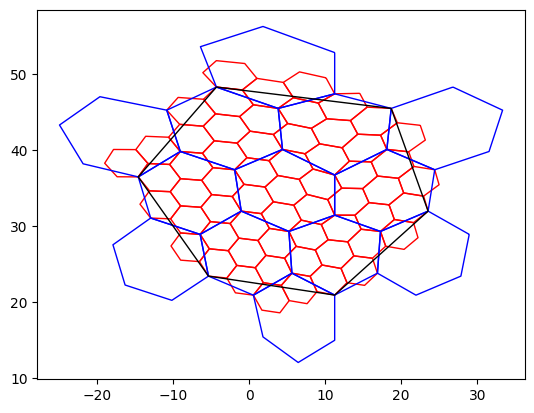

In [3]:
# to confirm the rotation is changing 19 from odd to even , -19 from even to odd 
box = shapely.geometry.box(2542500., 1561500. ,6013500., 5417500)
box = gpd.GeoSeries([box], crs='EPSG:3035').to_crs('wgs84')
reg5 = dggrid.grid_cell_polygons_for_extent('IGEO7', 1, clip_geom=box.geometry.values[0], output_address_type='Z7_STRING')
cellId = reg5['name'][0]
reg6 = dggrid.grid_cell_polygons_from_cellids([cellId], 'IGEO7', 2, clip_subset_type='COARSE_CELLS', clip_cell_res=1, input_address_type='Z7_STRING', output_address_type='Z7_STRING')
reg7 = dggrid.grid_cell_polygons_from_cellids([cellId], 'IGEO7', 3, clip_subset_type='COARSE_CELLS', clip_cell_res=1, input_address_type='Z7_STRING', output_address_type='Z7_STRING')
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1,)
reg7.plot(ax=ax,facecolor='none', edgecolor='red')
reg6.plot(ax =ax, facecolor='none',edgecolor='blue')
reg5[reg5['name'] == cellId].plot(ax=ax,facecolor='none')

In [4]:
directions = np.array([
           complex(0,0), # 0 
           complex(0.5,np.sqrt(3)/2), #1 
           complex(0.5,-np.sqrt(3)/2), #2
           complex(1,0), #3
           complex(-1,0), #4
           complex(-0.5,np.sqrt(3)/2), #5
           complex(-0.5,-np.sqrt(3)/2) #6 
        ])

In [5]:
# angele from CPI paper by Kevin 
angle = np.sqrt(3/28)
scale_down = 1/np.sqrt(7)
rotate_ccw19 = complex(np.cos(-angle), np.sin(-angle))
directions * ( scale_down * rotate_ccw19)

array([ 0.        +0.j        ,  0.28418807+0.24918724j,
        0.07370844-0.37070771j,  0.35789652-0.12152047j,
       -0.35789652+0.12152047j, -0.07370844+0.37070771j,
       -0.28418807-0.24918724j])

In [6]:
cell_ids = "33333"
path = [directions[int(cell_ids[0])]]
for i, c in enumerate(cell_ids[1:],1):
    print(path[-1])
    scaled_rotated = directions[int(c)] * ((scale_down**i * rotate_ccw19) if (i%2!=0) else (scale_down**i))
    path += [path[-1]+scaled_rotated]
print(path[-1])

(1+0j)
(1.3578965183866751-0.12152047145991135j)
(1.500753661243818-0.12152047145991135j)
(1.5518817352990573-0.13888053881132725j)
(1.5722898985643634-0.13888053881132725j)


In [7]:
current_pos = path[-1]

In [8]:
neighbours = current_pos + directions[1:]*(scale_down**(len(cell_ids)-1) * 1 )

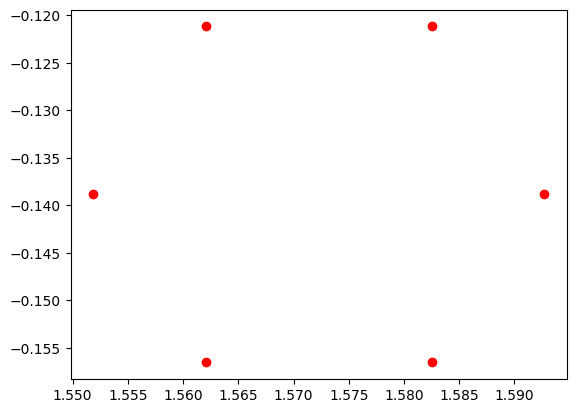

In [9]:
X = [x.real for x in neighbours]
Y = [x.imag for x in neighbours]
plt.scatter(X,Y, color='red')
plt.show()

In [10]:
def get_NN(neighbours, level, target=[]):
    rotation = rotate_ccw19 if (level%2==1) else 1
    # each neighbours's neighbours will contains original neighbours and the target
    # but it is not correct to exclude those "duplicated" neigbhours to reduce computation.
    # since it's neighbour may be the zero cell itself.
    exclude = target
    tmp_nn = np.repeat(neighbours,7).reshape(len(neighbours), -1)
    scaled_rotated_directions = directions*(scale_down**(level) * rotation)
    result = tmp_nn - scaled_rotated_directions
    idx,jdx = np.where(np.abs(result-exclude)<1e-9)
    result[idx,jdx]= np.inf
    result[:,0]=np.inf
    return result

In [14]:
nn = get_NN(neighbours, 4, [current_pos])
scaled_directions = directions * (scale_down**(len(cell_ids)-1) * rotate_ccw19)
all_zeros = path[-2] + 3  * scaled_directions

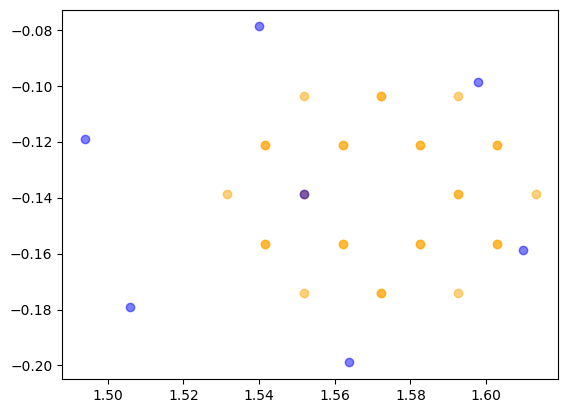

In [15]:
fig, ax = plt.subplots()
#X = [x.real for x in neighbours]
#Y = [x.imag for x in neighbours]
#ax.scatter(X,Y, color='red')
X1 = [i.real for i in nn.flatten() if (i != np.inf)]
Y1 = [i.imag for i in nn.flatten() if (i != np.inf)]
ax.scatter(X1,Y1, color='orange', alpha=0.5)
X2 = [i.real for i in all_zeros]
Y2 = [i.imag for i in all_zeros]
ax.scatter(X2,Y2, color='blue', alpha=0.5)

In [86]:
neighbours = current_pos + directions[1:]*(scale_down**(len(cell_ids)-1) * 1 )

In [87]:
new_path = [0] + path
for p in new_path[-2:-4:-1]:
    level = path.index(p)+1 if (p != 0) else 0
    p = new_path[0] if (p == 0) else p
    rotation = rotate_ccw19 if ((level+1)%2==1 and (p != 0)) else 1
    print(f'{p} , level {level} , rotation: {rotation}')
    nn = get_NN(neighbours, level, [current_pos])
    scaled_directions = directions * (scale_down**(level) * rotation)
    nearby_zeros = (p + 3  * scaled_directions).reshape(len(directions),1,1)
    # expand the dim to perform pair-wise distance (7 direction)
    distance_matrix = np.abs(np.repeat(nn[np.newaxis, :, :], len(directions), axis=0) - nearby_zeros) / (scale_down**(level))
    distance_matrix = np.min(distance_matrix, axis=0)
    distance_matrix = np.where(1-distance_matrix<1e-9,1,distance_matrix)
    print(distance_matrix)
    reverse_direction = np.argmin(distance_matrix,axis=-1)
    print(reverse_direction)
    neighbours = neighbours - directions[reverse_direction] * (scale_down**(level) * rotation)
    nearby_zeros= nearby_zeros.reshape(7,)
    neighbours = np.abs(np.repeat(neighbours[:, np.newaxis], len(directions), axis=-1) - nearby_zeros) / (scale_down**(level))
    neighbours = np.where(neighbours_new<1)[1]
    print(neighbours)
    neighbours = nearby_zeros[neighbours]

(1.5518817352990573-0.13888053881132725j) , level 4 , rotation: (0.9469051827469982-0.32151294668624764j)
[[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 3.54671654e-01]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  3.54671654e-01 1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  9.77602532e-01 3.54671654e-01 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.08801856e-14 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.08801856e-14 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00]]
[6 4 5 0 1 2]
[3 3 3 0 0 0]
(1.500753661243818-0.12152047145991135j) , level 3 , rotation: 1
[[1.         1.         1.         1.         1.         1.
  0.22908577]
 [1.         1.         1.         1.         1.         1.
  0.22

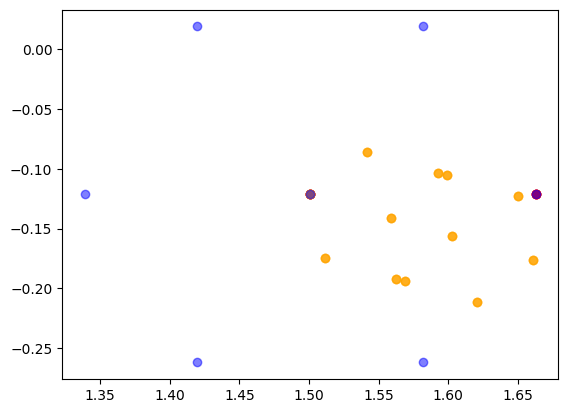

In [88]:
fig, ax = plt.subplots()
X = [x.real for x in neighbours]
Y = [x.imag for x in neighbours]
ax.scatter(X,Y, color='red')
X1 = [i.real for i in nn.flatten() if (i != np.inf)]
Y1 = [i.imag for i in nn.flatten() if (i != np.inf)]
ax.scatter(X1,Y1, color='orange', alpha=0.5)
X2 = [i.real for i in nearby_zeros]
Y2 = [i.imag for i in nearby_zeros]
ax.scatter(X2,Y2, color='blue', alpha=0.5)

In [ ]:
nearby_zeros.shape

In [ ]:
test_nn = np.abs(np.repeat(nn[np.newaxis, :, :], 7, axis=0) - nearby_zeros) / (scale_down**(len(cell_ids)-1))

In [ ]:
np.min(test_nn, axis=0)

In [ ]:
for k, v in nn.items():
        p = np.array([np.min(np.abs(i - nearby_zeros)) / (scale_down**(len(cell_ids)-1)) for i in v])
        p = np.where(1-p <1e-9,1,p)
        #print(p)
        if (len(np.unique(p)) == 1):
            # the neighbour itself is zero
            print(0)
        else:
            #print(np.argmin(p))
            print(len(directions) - (np.argmin(p)+1))            